In [43]:
import pandas as pd

df = pd.read_csv("lit-pcba_all_data.csv")
receptors = df.receptor.unique()
receptors

/tmp/ipykernel_1086742/1298370578.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("lit-pcba_all_data.csv")


array(['ADRB2', 'ALDH1', 'ESR1_ago', 'ESR1_ant', 'FEN1', 'GBA', 'IDH1',
       'KAT2A', 'MAPK1', 'MTORC1', 'OPRK1', 'PKM2', 'PPARG', 'TP53',
       'VDR'], dtype=object)

In [45]:
def get_duplicates(receptor):
    df_receptor = df[df["receptor"] == receptor]
    df_c_dupes = df_receptor[df_receptor.duplicated(subset=['canonical_smiles'], keep=False)].sort_values('canonical_smiles')
    return df_c_dupes

df_adbr2 = get_duplicates("ADRB2")
df_adbr2

,receptor,mol_id,smiles,type,canonical_smiles
159842,ADRB2,17414049,Br\C(\C=N\N1CC[NH+](Cc2ccccc2)CC1)=C/c3ccccc3,inactive_T,BrC(C=NN1CC[NH+](Cc2ccccc2)CC1)=Cc1ccccc1
91072,ADRB2,26661760,Br\C(\C=N\N1CC[NH+](Cc2ccccc2)CC1)=C\c3ccccc3,inactive_T,BrC(C=NN1CC[NH+](Cc2ccccc2)CC1)=Cc1ccccc1
163554,ADRB2,17407675,Br\C(\C=N\Nc1nc(N2CCOCC2)nc(N3CCOCC3)n1)=C\c4c...,inactive_T,BrC(C=NNc1nc(N2CCOCC2)nc(N2CCOCC2)n1)=Cc1ccccc1
153251,ADRB2,17509565,Br\C(\C=N\Nc1nc(N2CCOCC2)nc(N3CCOCC3)n1)=C/c4c...,inactive_T,BrC(C=NNc1nc(N2CCOCC2)nc(N2CCOCC2)n1)=Cc1ccccc1
265280,ADRB2,24841706,CC([C@@H]1C=C(C(NCC#C)=O)O[C@H](OCc2ccc(CO)cc2...,inactive_V,C#CCNC(=O)C1=CC(C(C)(C)C)CC(OCc2ccc(CO)cc2)O1
...,...,...,...,...,...
8047,ADRB2,81066504,[O-]\[N+](\c1ccccc1)=C/c2ccccc2,inactive_T,[O-][N+](=Cc1ccccc1)c1ccccc1
6835,ADRB2,85149110,C1Oc(c2O1)cc([C@H]3[C@@H]4[C@@H]([C@@H](c5cc(c...,inactive_T,c1cc2c(cc1C1OCC3C(c4ccc5c(c4)OCO5)OCC13)OCO2
1271,ADRB2,85272549,C1Oc(c2O1)cc([C@@H]3[C@@H]4[C@@H]([C@@H](c5cc(...,inactive_T,c1cc2c(cc1C1OCC3C(c4ccc5c(c4)OCO5)OCC13)OCO2
239804,ADRB2,56463293,C1SC(N2C1)=[NH+][C@@H](c3ccccc3)C2,inactive_V,c1ccc(C2CN3CCSC3=[NH+]2)cc1


## Helpers

In [46]:
from rdkit import Chem
from rdkit.Chem import Draw

def is_stereoisomer(s1, s2):
    m1, m2 = Chem.MolFromSmiles(s1), Chem.MolFromSmiles(s2)
    if not (m1 and m2): return False
    return (Chem.MolToSmiles(m1, isomericSmiles=False)
            == Chem.MolToSmiles(m2, isomericSmiles=False)) and \
           (Chem.MolToSmiles(m1, isomericSmiles=True)
            != Chem.MolToSmiles(m2, isomericSmiles=True))
           
def are_stereoisomers(smiles_list):
    # Returns True if all the smiles are same the molecule, but different stereoisomers
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    if any(m is None for m in mols):
        return False

    noniso = {Chem.MolToSmiles(m, canonical=True, isomericSmiles=False) for m in mols}
    if len(noniso) != 1:
        return False

    iso = [Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mols]
    iso_set = set(iso)

    if len(iso_set) != len(iso):
        return False
    return True
           
def draw(smiles, row=5):
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    display(Draw.MolsToGridImage(mols, molsPerRow=row))
    

## Examining cases of duplicates on ADBR2

In [52]:
counts = df_adbr2['canonical_smiles'].value_counts()
if not (counts == 2).all():
    bad = counts[counts != 2]
    raise Exception(f"These canonical_smiles have even more than 2 duplicates \n{bad}")

Exception: These canonical_smiles have even more than 2 duplicates 
COC(CC1OC1C(O)C(C)OCc1ccccc1)OC                                     10
CC(C)(C)OC(=O)CC1CC=CCC(CC(=O)NC(CO)Cc2ccccc2)C(=O)N2CCCC2COC1=O    10
OCCC1CC(O)C(O)C2(Cc3ccccc3CO2)O1                                     8
OCCC1CC(O)C(O)C2(CCc3ccccc3CO2)O1                                    8
OCCC1CC(O)C(O)C2(Cc3ccccc3O2)O1                                      8
                                                                    ..
CC(=O)CC(O)CC(=O)C1OC(=O)CCCCCC=CCc2ccccc21                          3
CC1COC(=O)C(Cc2ccc(F)cc2)CCC=CCC(CC(=O)NC(CO)Cc2ccccc2)C(=O)N1       3
CC(C)CC(CO)N(Cc1ccccc1)S(=O)(=O)N(Cc1ccccc1)C(CO)CC(C)C              3
O=C(CC1CC=CCC(Cc2ccc(F)cc2)C(=O)OC(c2ccccc2)CNC1=O)NCCO              3
O=C(CC1CC=CCC(Cc2ccc(F)cc2)C(=O)OCC(Cc2c[nH]c3ccccc23)NC1=O)NCCO     3
Name: canonical_smiles, Length: 127, dtype: int64

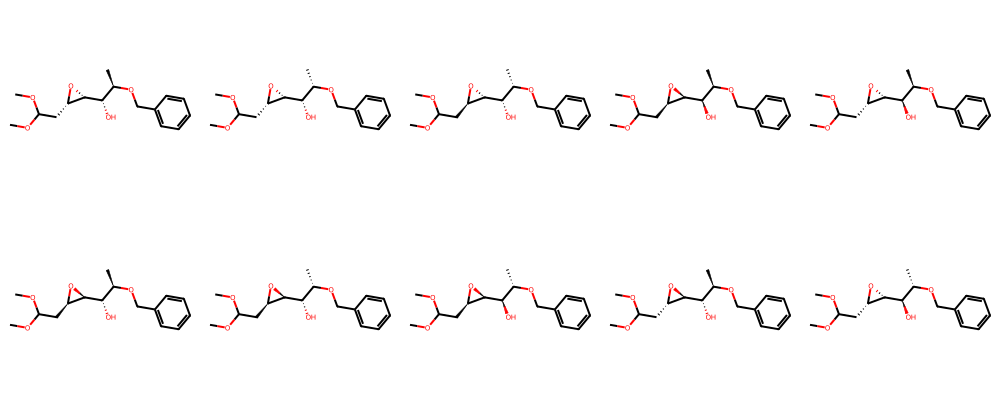

Are all of them stereoisomers? True


In [49]:
df_weird = df_adbr2[df_adbr2['canonical_smiles'] == "COC(CC1OC1C(O)C(C)OCc1ccccc1)OC"]
draw(df_weird.smiles[0:20])
print("Are all of them stereoisomers?", are_stereoisomers(df_weird.smiles))

### All "duplicates" cases on ADBR2

In [50]:
from tqdm import tqdm

stereoisomers = []
for c in tqdm(df_adbr2.canonical_smiles.unique()):
    smiles = df_adbr2[df_adbr2['canonical_smiles'] == c].smiles
    stereoisomers.append(are_stereoisomers(smiles))
    
just_stereoisomers = sum(stereoisomers) # counts True (True==1, False==0)
genuine_duplicates = len(stereoisomers) - just_stereoisomers

print(just_stereoisomers)
print(genuine_duplicates)

100%|██████████| 1439/1439 [00:02<00:00, 554.63it/s]

1438
1


In [58]:
the_single_duplicate = stereoisomers.index(False)
smiles_of_it = df_adbr2.canonical_smiles.unique()[the_single_duplicate]
df_adbr2[df_adbr2['canonical_smiles'] == smiles_of_it]
# so this is just in the "query set". might be based on wrong conversion from mol2 file

,receptor,mol_id,smiles,type,canonical_smiles
311765,ADRB2,3p0g,Cc1ccccc1CC(C)(C)NC[C@@H](c2ccc(c3c2OCC(=O)N3)O)O,query,Cc1ccccc1CC(C)(C)NCC(O)c1ccc(O)c2c1OCC(=O)N2
311768,ADRB2,4lde,Cc1ccccc1CC(C)(C)NC[C@@H](c2ccc(c3c2OCC(=O)N3)O)O,query,Cc1ccccc1CC(C)(C)NCC(O)c1ccc(O)c2c1OCC(=O)N2
311767,ADRB2,3sn6,Cc1ccccc1CC(C)(C)NC[C@@H](c2ccc(c3c2OCC(=O)N3)O)O,query,Cc1ccccc1CC(C)(C)NCC(O)c1ccc(O)c2c1OCC(=O)N2


## Run on all receptors

In [60]:
receptor_duplicates = {}
for receptor in tqdm(receptors, desc="Processing receptors"):
    receptor_duplicates[receptor] = get_duplicates(receptor)

Processing receptors: 100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


In [65]:
# Analyze stereoisomers vs genuine duplicates for each receptor
results = {}
genuine_duplicates_data = []

for receptor in tqdm(receptors, desc="Analyzing stereoisomers"):
    df_receptor_dupes = receptor_duplicates[receptor]
    
    if len(df_receptor_dupes) == 0:
        results[receptor] = {
            'total_duplicate_groups': 0,
            'stereoisomer_groups': 0,
            'genuine_duplicate_groups': 0,
            'total_molecules': 0
        }
        continue
    
    stereoisomers = []
    genuine_duplicates_for_receptor = []
    
    for canonical_smiles in df_receptor_dupes.canonical_smiles.unique():
        df_group = df_receptor_dupes[df_receptor_dupes['canonical_smiles'] == canonical_smiles]
        smiles_group = df_group.smiles
        types_group = df_group.type
        
        if are_stereoisomers(smiles_group):
            stereoisomers.append(True)
        else:
            stereoisomers.append(False)
            # Store genuine duplicates info
            genuine_duplicates_for_receptor.append({
                'receptor': receptor,
                'canonical_smiles': canonical_smiles,
                'smiles_list': smiles_group.tolist(),
                'types_list': types_group.tolist(),
                'count': len(smiles_group)
            })
    
    # Store genuine duplicates for later analysis
    genuine_duplicates_data.extend(genuine_duplicates_for_receptor)
    
    just_stereoisomers = sum(stereoisomers)
    genuine_duplicate_groups = len(stereoisomers) - just_stereoisomers
    
    results[receptor] = {
        'total_duplicate_groups': len(stereoisomers),
        'stereoisomer_groups': just_stereoisomers,
        'genuine_duplicate_groups': genuine_duplicate_groups,
        'total_molecules': len(df_receptor_dupes)
    }


Analyzing stereoisomers: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


In [75]:
print("="*80)
print("STEREOISOMER vs GENUINE DUPLICATES ANALYSIS")
print("="*80)
print()

summary_df = pd.DataFrame.from_dict(results, orient='index')
summary_df = summary_df.sort_values('genuine_duplicate_groups', ascending=False)

print("Summary by Receptor:")
print("-" * 60)
for receptor, data in summary_df.iterrows():
    print(f"{receptor:12} | Total Redundancies: {data['total_duplicate_groups']:4d} | "
          f"Stereoisomers: {data['stereoisomer_groups']:4d} | "
          f"Genuine Duplicates: {data['genuine_duplicate_groups']:4d} | "
          f"Total Molecules: {data['total_molecules']:4d}")

print()
print("Overall Summary:")
print("-" * 40)
total_groups = summary_df['total_duplicate_groups'].sum()
total_stereoisomers = summary_df['stereoisomer_groups'].sum()
total_genuine = summary_df['genuine_duplicate_groups'].sum()
total_molecules = summary_df['total_molecules'].sum()

print(f"Total 'duplicate' groups: {total_groups}")
print(f"Groups that are stereoisomers: {total_stereoisomers} ({100*total_stereoisomers/total_groups:.1f}%)")
print(f"Groups with possibly genuine duplicates: {total_genuine} ({100*total_genuine/total_groups:.1f}%)")
print(f"Total molecules in duplicate groups: {total_molecules}")

STEREOISOMER vs GENUINE DUPLICATES ANALYSIS

Summary by Receptor:
------------------------------------------------------------
MTORC1       | Total Redundancies:    3 | Stereoisomers:    0 | Genuine Duplicates:    3 | Total Molecules:    9
PKM2         | Total Redundancies:  980 | Stereoisomers:  978 | Genuine Duplicates:    2 | Total Molecules: 2026
ADRB2        | Total Redundancies: 1439 | Stereoisomers: 1438 | Genuine Duplicates:    1 | Total Molecules: 3180
VDR          | Total Redundancies: 1458 | Stereoisomers: 1457 | Genuine Duplicates:    1 | Total Molecules: 3300
ALDH1        | Total Redundancies:  655 | Stereoisomers:  655 | Genuine Duplicates:    0 | Total Molecules: 1416
ESR1_ago     | Total Redundancies:   54 | Stereoisomers:   54 | Genuine Duplicates:    0 | Total Molecules:  113
ESR1_ant     | Total Redundancies:   45 | Stereoisomers:   45 | Genuine Duplicates:    0 | Total Molecules:   94
FEN1         | Total Redundancies: 1807 | Stereoisomers: 1807 | Genuine Duplicates

In [ ]:
for i, dup_info in enumerate(genuine_duplicates_data, 1):
    print(f"Group {i}: Receptor {dup_info['receptor']}")
    print(f"Canonical SMILES: {dup_info['canonical_smiles']}")
    print(f"Count: {dup_info['count']} molecules")
    print("Individual SMILES:")
    for j, smiles in enumerate(dup_info['smiles_list'], 1):
        print(f"  {j}. {smiles}")
    print("Individual Dataset Types:")
    for j, smiles in enumerate(dup_info['types_list'], 1):
        print(f"  {j}. {smiles}")
    print("-" * 80)

Group 1: Receptor ADRB2
Canonical SMILES: Cc1ccccc1CC(C)(C)NCC(O)c1ccc(O)c2c1OCC(=O)N2
Count: 3 molecules
Individual SMILES:
  1. Cc1ccccc1CC(C)(C)NC[C@@H](c2ccc(c3c2OCC(=O)N3)O)O
  2. Cc1ccccc1CC(C)(C)NC[C@@H](c2ccc(c3c2OCC(=O)N3)O)O
  3. Cc1ccccc1CC(C)(C)NC[C@@H](c2ccc(c3c2OCC(=O)N3)O)O
Individual Dataset Types:
  1. query
  2. query
  3. query
--------------------------------------------------------------------------------
Group 2: Receptor MTORC1
Canonical SMILES: CCOC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC(C(C)CC2CCC(O)C(OC)C2)CC(=O)C(C)C=C(C)C(O)C(OC)C(=O)C(C)CC(C)C=CC=CC=C1C
Count: 2 molecules
Individual SMILES:
  1. CCO[C@H]\1C[C@@H]2CC[C@H]([C@@](O2)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@@H](CC(=O)[C@@H](/C=C(/[C@H]([C@H](C(=O)[C@@H](C[C@@H](/C=C/C=C/C=C1\C)C)C)OC)O)\C)C)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)O)C
  2. CCO[C@H]\1C[C@@H]2CC[C@H]([C@@](O2)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@@H](CC(=O)[C@@H](/C=C(/[C@H]([C@H](C(=O)[C@@H](C[C@@H](/C=C/C=C/C=C1\C)C)C)OC)O)\C)C)[C@H](C)C[C@

In [88]:
# OK, so all the duplicate cases (just 7) involve query set smiles from the rcsb 
# Those smiles are fetched by the authors – not present in the original LIT-PCBA Benchmark
# let's investigate them

## 'Duplicate' Query Set Smiles

In [86]:
df_query = pd.read_csv("pdb_to_ligand_mapping_with_smiles.csv")
df_query_duplicates = df_query[df_query.duplicated(subset=['smiles'], keep=False)].sort_values('smiles')
df_query_duplicates

,pdb_id,ligand_id,smiles
127,3A2I,TEJ,C=C1C[C@H](C[C@H](C)[C@H]2CC[C@H]3/C(=C/C=C4/C...
128,3A2J,TEJ,C=C1C[C@H](C[C@H](C)[C@H]2CC[C@H]3/C(=C/C=C4/C...
86,1NSG,RAD,CCO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C...
87,2FAP,RAD,CCO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C...
88,3FAP,ARD,CO[C@@H]1C[C@H](C[C@@H](C)[C@@H]2CC(=O)[C@H](C...
92,4FAP,ARD,CO[C@@H]1C[C@H](C[C@@H](C)[C@@H]2CC(=O)[C@H](C...
85,1FAP,RAP,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...
89,4DRH,RAP,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...
90,4DRI,RAP,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...
91,4DRJ,RAP,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...


In [ ]:
# Oh wait, do you see it?
# in get_smiles_from_ligand_ids.py there is 
#
# for row in reader:
#     ligand_id = row['ligand_id']
#     print(f"Processing ligand_id: {ligand_id}")    
#     url = f"https://files.rcsb.org/ligands/download/{ligand_id}_ideal.sdf"
#
# and the reader is csv pdb_to_ligand_mapping.csv which looks like this
# pdb_id,ligand_id
# 3P0G,P0G
# 3PDS,ERC
# 3SN6,P0G
# 4LDE,P0G
# 
# Since you are fetching ligand_id, you fetch the same mol2 file for P0G 3 times!
# Obviously the same mol2 file will have the same smiles
